In [ ]:
import os
import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module, Conv2d, ConvTranspose2d, MaxPool2d, ReLU, Sigmoid, Sequential, ModuleList, BatchNorm2d
from torch.optim import AdamW

from torchvision.io import decode_image
from tqdm.notebook import trange

from data.image_dataset import ImageDataset
from utils.masking import mask_image, mask_batch
from utils.notebook import imshow
from utils.tensor import numpy_to_tensor, tensor_to_numpy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device.type

'cuda'

In [2]:
class UNet(Module):
    def __init__(self):
        super(UNet, self).__init__()

        # encoder
        self.conv1 = Conv2d(3, 64, kernel_size=3, padding="same")
        self.conv2 = Conv2d(64, 64, kernel_size=3, padding="same")
        self.pool1 = MaxPool2d(kernel_size=2)
        self.conv3 = Conv2d(64, 128, kernel_size=3, padding="same")
        self.conv4 = Conv2d(128, 128, kernel_size=3, padding="same")
        self.pool2 = MaxPool2d(kernel_size=2)
        self.conv5 = Conv2d(128, 256, kernel_size=3, padding="same")
        self.conv6 = Conv2d(256, 256, kernel_size=3, padding="same")
        self.pool3 = MaxPool2d(kernel_size=2)
        self.conv7 = Conv2d(256, 512, kernel_size=3, padding="same")
        self.conv8 = Conv2d(512, 512, kernel_size=3, padding="same")
        self.pool4 = MaxPool2d(kernel_size=2)

        # bottleneck
        self.conv9 = Conv2d(512, 1024, kernel_size=3, padding="same")
        self.conv10 = Conv2d(1024, 1024, kernel_size=3, padding="same")

        # decoder
        self.upconv1 = ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv11 = Conv2d(1024, 512, kernel_size=3, padding="same")
        self.conv12 = Conv2d(512, 512, kernel_size=3, padding="same")
        self.upconv2 = ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv13 = Conv2d(512, 256, kernel_size=3, padding="same")
        self.conv14 = Conv2d(256, 256, kernel_size=3, padding="same")
        self.upconv3 = ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv15 = Conv2d(256, 128, kernel_size=3, padding="same")
        self.conv16 = Conv2d(128, 128, kernel_size=3, padding="same")
        self.upconv4 = ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv17 = Conv2d(128, 64, kernel_size=3, padding="same")
        self.conv18 = Conv2d(64, 64, kernel_size=3, padding="same")
        self.conv19 = Conv2d(64, 3, kernel_size=1)

        self.relu = ReLU()
        self.sigmoid = Sigmoid()

    def forward(self, x):
        # encoder
        x = self.relu(self.conv1(x))
        skip4 = self.relu(self.conv2(x))
        x = self.pool1(skip4)
        
        x = self.relu(self.conv3(x))
        skip3 = self.relu(self.conv4(x))
        x = self.pool2(skip3)
        
        x = self.relu(self.conv5(x))
        skip2 = self.relu(self.conv6(x))
        x = self.pool3(skip2)

        x = self.relu(self.conv7(x))
        skip1 = self.relu(self.conv8(x))
        x = self.pool4(skip1)

        # bottleneck
        x = self.relu(self.conv9(x))
        x = self.relu(self.conv10(x))

        # decoder
        x = self.upconv1(x)
        x = torch.cat((x, skip1), dim=1)
        x = self.relu(self.conv11(x))
        x = self.relu(self.conv12(x))

        x = self.upconv2(x)
        x = torch.cat((x, skip2), dim=1)
        x = self.relu(self.conv13(x))
        x = self.relu(self.conv14(x))

        x = self.upconv3(x)
        x = torch.cat((x, skip3), dim=1)
        x = self.relu(self.conv15(x))
        x = self.relu(self.conv16(x))

        x = self.upconv4(x)
        x = torch.cat((x, skip4), dim=1)
        x = self.relu(self.conv17(x))
        x = self.relu(self.conv18(x))
        x = self.sigmoid(self.conv19(x))

        return x

In [3]:
model = UNet().to(device)
model

UNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv9): Conv2d(512, 1024, kernel_size

In [4]:
img = cv2.imread('../.images/test_256/Places365_test_00003209.jpg')
assert img is not None, "Image not found"

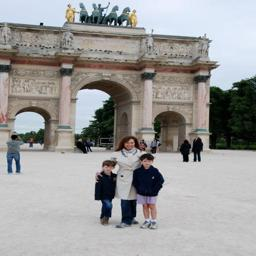

In [5]:
imshow(img)

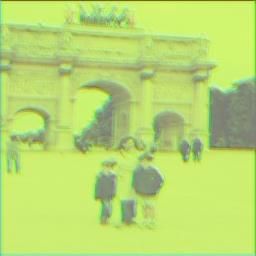

In [6]:
model.eval()
with torch.no_grad():
    tensor = numpy_to_tensor(img).unsqueeze(0).to(device)
    output = model(tensor)
    result = tensor_to_numpy((output*255).squeeze(0))
imshow(result)

In [7]:
dataset = ImageDataset('../.images/test_256')

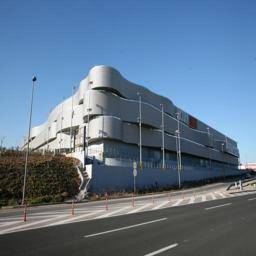

In [8]:
dataset.show_image(0)

In [9]:
train_dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [14]:
from tqdm.notebook import tqdm

In [35]:
from torch.nn import MSELoss

optimizer = AdamW(model.parameters(), lr=1e-4)
loss_fn = MSELoss()

num_epochs = 5

for epoch in trange(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch in tqdm(train_dataloader):
        batch = batch.to(device).float() / 255.0  # Convert to float and normalize
        masked_batch = mask_batch(batch)
        
        # Forward pass
        output = model(masked_batch)
        
        # Compute loss (reconstruction loss)
        loss = loss_fn(output, batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

Epoch 1/5, Loss: 0.0015


  0%|          | 0/803 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'unet_model.pth')

In [26]:
def mask_tensor(img: torch.Tensor) -> torch.Tensor:
    width, height = img.shape[2], img.shape[1]
    padding = 30
    min_size = 30
    max_size = 80

    box_width = np.random.randint(min_size, max_size)
    box_height = np.random.randint(min_size, max_size)
    print(width, height)
    print(box_width, box_height)
    print(width - padding - box_width, height - padding - box_height)
    anchor = np.random.randint(0+padding, width - padding - box_width), np.random.randint(0+padding, height - padding - box_height)

    img[:, anchor[1]:anchor[1]+box_height, anchor[0]:anchor[0]+box_width] = 0
    return img

torch.Size([1, 3, 256, 256])
Image 1


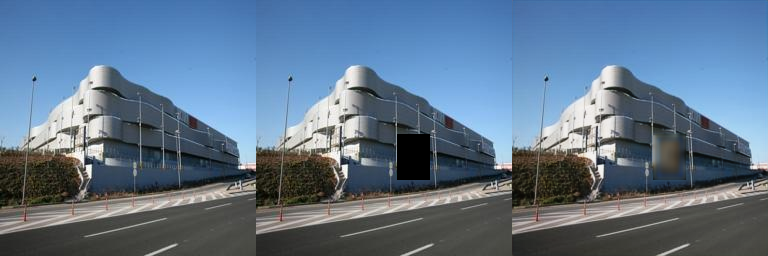

torch.Size([1, 3, 256, 256])
Image 2


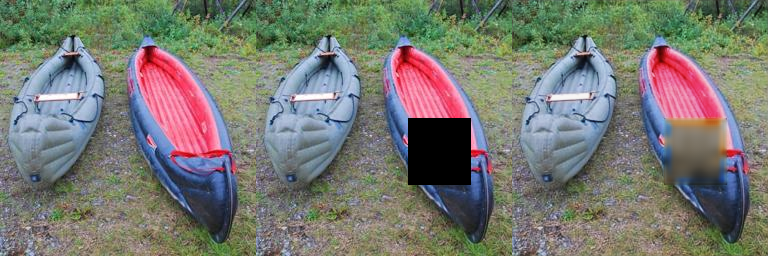

torch.Size([1, 3, 256, 256])
Image 3


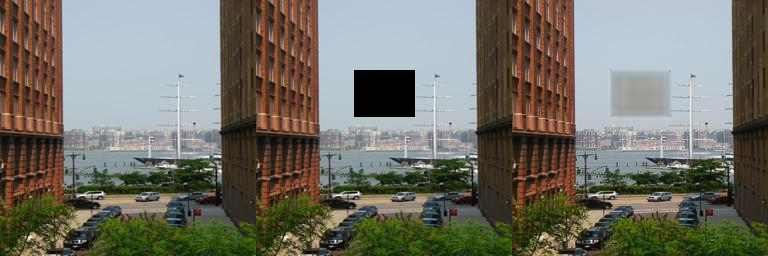

torch.Size([1, 3, 256, 256])
Image 4


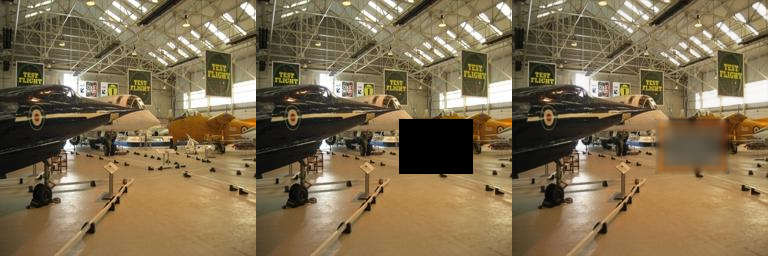

torch.Size([1, 3, 256, 256])
Image 5


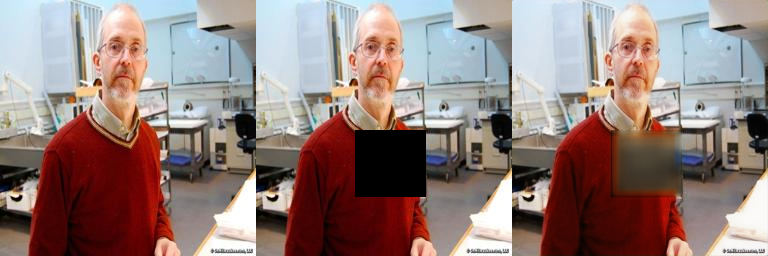

In [34]:
model.eval()
with torch.no_grad():
    for i in range(5):
        img = dataset[i]
        img_tensor = img.to(device).float() / 255.0
        img_tensor = img_tensor.unsqueeze(0)
        print(img_tensor.shape)
        masked_img_tensor = mask_batch(img_tensor)
        
        output = model(masked_img_tensor)
        output_img = tensor_to_numpy((output*255).squeeze(0), bgr=True)
        masked_img = tensor_to_numpy((masked_img_tensor*255).squeeze(0), bgr=True)
        original_img = tensor_to_numpy((img_tensor*255).squeeze(0), bgr=True)
        
        print(f"Image {i+1}")
        imshow(np.concatenate((original_img, masked_img, output_img), axis=1))